# Setting up

Installing all essential packages and preprocess the video before feeding them to the model

In [ ]:
!pip install ultralytics

In [ ]:
import os
import cv2
import math
from IPython.display import HTML
from base64 import b64encode
from ultralytics import YOLO
import matplotlib.pyplot as plt

Create /datasets folder

In [ ]:
os.makedirs(f"/content/datasets/test", exist_ok=True)

Drag the recorded videos to the /datasets folder

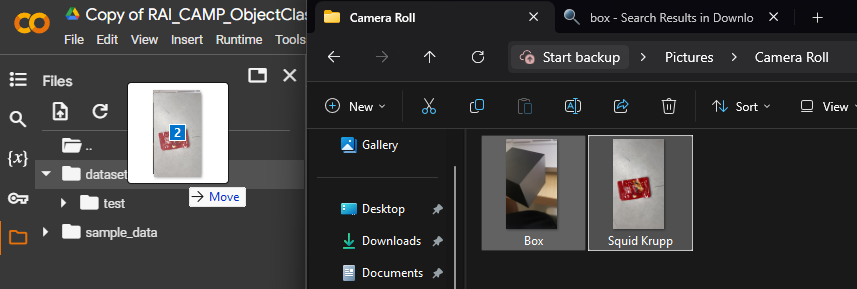

Result

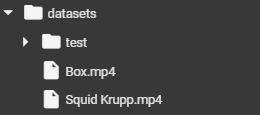

Display Videos

In [ ]:
base_dir = '/content/datasets'
target_duration = 10

def show_video(video_path, video_width=600):
    with open(video_path, "rb") as video_file:
        video_data = video_file.read()
        video_url = f"data:video/mp4;base64,{b64encode(video_data).decode()}"
        return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

video_files = [file for file in os.listdir(base_dir) if file.endswith('.mp4')]

for video_file in video_files:
    video_path = os.path.join(base_dir, video_file)
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(1, int(total_frames / (fps * target_duration)))

    frames = []
    frame_count = 0
    success, frame = cap.read()
    while success and frame_count < total_frames:
        if frame_count % frame_interval == 0:
            frames.append(frame)
        success, frame = cap.read()
        frame_count += 1

    normalized_video_path = os.path.join(base_dir, f"{video_file}")
    height, width, layers = frames[0].shape
    out = cv2.VideoWriter(normalized_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    for frame in frames:
        out.write(frame)
    out.release()
    cap.release()

    print(f"Displaying normalized video for: {video_file}")
    display(show_video(normalized_video_path))

# Split Frames


Extract frames from each video and also split into train and validate dataset to train the YOLO model

In [ ]:
def create_output_directories(base_output_dir, video_name):
    os.makedirs(f"{base_output_dir}/train/{video_name}", exist_ok=True)
    os.makedirs(f"{base_output_dir}/val/{video_name}", exist_ok=True)

def save_frame(image, output_dir, frame_count):
    file_name = os.path.join(output_dir, f"{frame_count:04d}.png")
    cv2.imwrite(file_name, image)

def split_frames(video_path, video_name, base_output_dir, frames_per_second=5, split_ratio=0.8, max_frames=20):

    create_output_directories(base_output_dir, video_name)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_name}")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_interval = max(1, int(fps / frames_per_second))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    total_extracted_frames = min(total_frames // frame_interval, max_frames)
    train_frame_limit = math.ceil(total_extracted_frames * split_ratio)

    count = 0
    frame_number = 0
    success, image = cap.read()
    while success and count < total_extracted_frames:
        if frame_number % frame_interval == 0:
            output_subdir = "train" if count < train_frame_limit else "val"
            output_dir = f"{base_output_dir}/{output_subdir}/{video_name}"
            save_frame(image, output_dir, count)
            count += 1
        success, image = cap.read()
        frame_number += 1

    cap.release()
    print(f"Frames split and saved for video: {video_name}")

for video_file in video_files:
    video_path = os.path.join(base_dir, video_file)
    video_name = os.path.splitext(video_file)[0]
    split_frames(video_path, video_name, base_dir)

print("Frame extraction and splitting completed.")

In [ ]:
def display_frames_row_format(base_output_dir, video_name, samples_per_folder=5):
    fig, ax = plt.subplots(2, samples_per_folder + 1, figsize=(15, 5))
    fig.suptitle(f"Frames for Video: {video_name}", fontsize=16)

    ax[0, 0].text(0.5, 0.5, "Train", ha="center", va="center", fontsize=12)
    ax[0, 0].axis('off')
    train_folder = os.path.join(base_output_dir, "train", video_name)
    train_frames = [file for file in os.listdir(train_folder) if file.endswith('.png')][:samples_per_folder]

    for i, frame_file in enumerate(train_frames):
        frame_path = os.path.join(train_folder, frame_file)
        image = cv2.imread(frame_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax[0, i + 1].imshow(image_rgb)
        ax[0, i + 1].axis('off')

    ax[1, 0].text(0.5, 0.5, "Validation", ha="center", va="center", fontsize=12)
    ax[1, 0].axis('off')
    val_folder = os.path.join(base_output_dir, "val", video_name)
    val_frames = [file for file in os.listdir(val_folder) if file.endswith('.png')][:samples_per_folder]

    for i, frame_file in enumerate(val_frames):
        frame_path = os.path.join(val_folder, frame_file)
        image = cv2.imread(frame_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax[1, i + 1].imshow(image_rgb)
        ax[1, i + 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

for video_file in video_files:
    video_name = os.path.splitext(video_file)[0]
    display_frames_row_format(base_dir, video_name)

# Train the model

Use the image data that we preprocess earlier to train the classificaiton algorithm

In [ ]:
model = YOLO('yolov8n-cls.pt')
model.train(data='/content/datasets', epochs=5)

# Model evaluation

Evaluating model performance by letting it predict the images

In [ ]:
def perform_inference(model, image_path):
    image = cv2.imread(image_path)

    results = model(image_path)

    predicted_class = results[0].names[results[0].probs.top1]
    confidence = results[0].probs.top1conf.item()

    display_image_with_prediction(image, predicted_class, confidence)

def display_image_with_prediction(image, predicted_class, confidence):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.title(f"Prediction: {predicted_class}, Confidence: {confidence*100:.2f}%")
    plt.axis('off')
    plt.show()

In [ ]:
def process_images_in_folder(model, folder_path):
    supported_extensions = ('.png', '.jpg')

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(supported_extensions):
            image_path = os.path.join(folder_path, filename)
            print(f"Processing image: {image_path}")
            perform_inference(model, image_path)

test_folder_path = '/content/datasets/test'

process_images_in_folder(model, test_folder_path)
